<a href="https://colab.research.google.com/github/davidguzmanr/Aprendizaje-Profundo/blob/main/Tareas/Tarea-1/Tarea_1_ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: perceptrón y redes densas

- **E. David Guzmán Ramírez**
- **Introducción al Aprendizaje Profundo 2021-II**
- **Licenciatura en Ciencia de Datos CU UNAM**

In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

from collections import Counter
from itertools import islice as take
from tqdm import trange, tqdm

sns.set_style('darkgrid')

## Ejercicio 4

Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10 (puedes usar todas las herramientas de PyTorch). (3 puntos)

### Carga de datos y exploración

**Solución.** (ver [CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) para cargar el dataset).

In [3]:
# Los pasa a tensores y las normaliza con media=0.5 y desv_est=0.5 en cada canal.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = dict(zip(range(0,10), classes))

Files already downloaded and verified
Files already downloaded and verified


Vemos que hay 50,000 imágenes en el dataset de entrenamiento y 10,000 en el de prueba. Además, tanto en el dataset de entrenamiento como el de prueba las clases están completamente balanceadas.

In [4]:
len(trainset), len(testset)

(50000, 10000)

In [5]:
train_class_counter = Counter([classes_dict[y] for (x, y) in trainset])
train_class_counter

Counter({'bird': 5000,
         'car': 5000,
         'cat': 5000,
         'deer': 5000,
         'dog': 5000,
         'frog': 5000,
         'horse': 5000,
         'plane': 5000,
         'ship': 5000,
         'truck': 5000})

In [6]:
test_class_counter = Counter([classes_dict[y] for (x, y) in testset])
test_class_counter

Counter({'bird': 1000,
         'car': 1000,
         'cat': 1000,
         'deer': 1000,
         'dog': 1000,
         'frog': 1000,
         'horse': 1000,
         'plane': 1000,
         'ship': 1000,
         'truck': 1000})

Ahora veamos algunas imágenes en el dataset.

In [7]:
def show_images(images, true_labels, pred_labels=None):
    """
    Muestra un lote de imágenes con su respectiva clase.
    """

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

    for i, _ in enumerate(axes):
        axes[i].imshow(images[i].permute(1,2,0).numpy()/2 + 0.5) # Desnormalizamos
        axes[i].axis('off')

    if pred_labels:
        for i, _ in enumerate(axes):
            axes[i].set_title(f'true_label={classes_dict[true_labels[i].item()]}\npred_label={classes_dict[pred_labels[i].item()]}')
    else:
        for i, _ in enumerate(axes):
            axes[i].set_title(f'true_label={classes_dict[true_labels[i].item()]}')

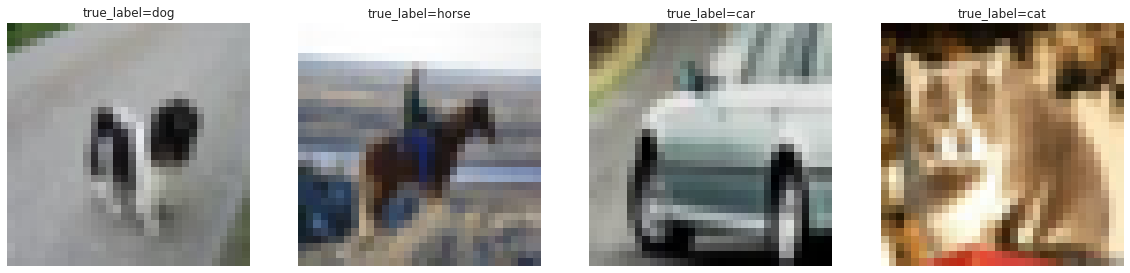

In [8]:
images, true_labels = next(iter(trainloader))
show_images(images, true_labels)

### Definición del modelo

Ahora definimos nuestro modelo, como estamos *aplanando* una imagen de $32 \times 32 \times 3$ la capa inicial es muy grande y en consecuencia tendremos muchos parámetros, por lo que es conveniente que las siguientes capas no sean muy grandes para que no haya tantos parámetros.

In [9]:
class FCN(nn.Module):
    # inicializador
    def __init__(self):        
        # inicilización del objeto padre
        super(FCN, self).__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2 = 16, 10
        
        # definición de capas
        self.cls = nn.Sequential(            
            # fc1
            # [M, 3x32x32] => [M, 16]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            # fc2
            # [M, 16] => [M, 10]
            nn.Linear(FC1, FC2),
            nn.ReLU(),        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 10]
        x = self.cls(x)
        
        return x

In [10]:
def train_epoch(dataloader, model, opt):

    # por cada lote
    for x, y_true in dataloader:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()

In [11]:
def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc

In [12]:
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20, trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Instanciamos nuestro modelo y vemos cuántos parámetros tiene.

In [13]:
torch.manual_seed(42)

# Definimos nuestro modelo y probamos con unos datos sintéticos
model = FCN()
x = torch.zeros(3*32*32)
model(x)

tensor([[0.0926, 0.0910, 0.0382, 0.0000, 0.0000, 0.0000, 0.0219, 0.0000, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)

In [14]:
summary(model, (3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 16]                   49,168
|    └─ReLU: 2-2                         [1, 16]                   --
|    └─Linear: 2-3                       [1, 10]                   170
|    └─ReLU: 2-4                         [1, 10]                   --
Total params: 49,338
Trainable params: 49,338
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21

### Entrenamiento

In [15]:
# Entrenamos
loss_hist, acc_hist = train(model, trainloader, testloader, lr=0.01)

  5%|▌         | 1/20 [01:29<28:16, 89.30s/it]

E00 loss=[173.61,175.61] acc=[39.36,38.79]


 10%|█         | 2/20 [02:57<26:41, 88.98s/it]

E01 loss=[170.26,174.18] acc=[40.55,39.00]


 15%|█▌        | 3/20 [04:27<25:19, 89.36s/it]

E02 loss=[166.71,172.81] acc=[42.19,39.86]


 20%|██        | 4/20 [05:56<23:47, 89.22s/it]

E03 loss=[164.50,172.16] acc=[42.53,39.55]


 25%|██▌       | 5/20 [07:26<22:19, 89.28s/it]

E04 loss=[164.20,171.60] acc=[42.93,40.29]


 30%|███       | 6/20 [08:55<20:51, 89.42s/it]

E05 loss=[163.07,171.81] acc=[43.30,40.52]


 35%|███▌      | 7/20 [10:27<19:31, 90.09s/it]

E06 loss=[162.07,171.92] acc=[43.49,40.53]


 40%|████      | 8/20 [11:56<17:55, 89.66s/it]

E07 loss=[164.69,175.09] acc=[42.82,39.15]


 45%|████▌     | 9/20 [13:24<16:21, 89.19s/it]

E08 loss=[153.15,164.09] acc=[46.61,43.62]


 50%|█████     | 10/20 [14:55<14:58, 89.84s/it]

E09 loss=[150.78,163.64] acc=[47.37,43.70]


 55%|█████▌    | 11/20 [16:25<13:27, 89.77s/it]

E10 loss=[147.84,161.85] acc=[47.81,42.60]


 60%|██████    | 12/20 [17:53<11:55, 89.41s/it]

E11 loss=[146.24,161.06] acc=[48.77,43.11]


 65%|██████▌   | 13/20 [19:23<10:27, 89.64s/it]

E12 loss=[148.23,163.02] acc=[48.39,43.74]


 70%|███████   | 14/20 [20:54<08:59, 89.84s/it]

E13 loss=[147.22,161.97] acc=[48.48,43.68]


 75%|███████▌  | 15/20 [22:25<07:30, 90.13s/it]

E14 loss=[144.26,161.28] acc=[49.24,43.66]


 80%|████████  | 16/20 [23:54<05:59, 89.90s/it]

E15 loss=[147.69,164.83] acc=[47.67,42.38]


 85%|████████▌ | 17/20 [25:25<04:30, 90.19s/it]

E16 loss=[145.19,163.72] acc=[48.78,43.13]


 90%|█████████ | 18/20 [26:54<02:59, 89.92s/it]

E17 loss=[146.12,165.50] acc=[48.46,42.88]


 95%|█████████▌| 19/20 [28:26<01:30, 90.39s/it]

E18 loss=[144.75,163.41] acc=[48.98,43.10]


100%|██████████| 20/20 [29:59<00:00, 89.96s/it]

E19 loss=[144.96,164.73] acc=[48.80,42.86]


  5%|▌         | 1/20 [01:25<26:57, 85.16s/it]E00 loss=[199.42,199.91] acc=[31.01,30.76]
 10%|█         | 2/20 [02:48<25:22, 84.60s/it]E01 loss=[192.64,193.37] acc=[33.40,33.38]
 15%|█▌        | 3/20 [04:14<24:03, 84.89s/it]E02 loss=[186.67,187.56] acc=[35.89,35.77]
 20%|██        | 4/20 [05:39<22:41, 85.08s/it]E03 loss=[182.24,183.33] acc=[36.81,36.69]
 25%|██▌       | 5/20 [07:02<21:08, 84.55s/it]E04 loss=[175.00,176.07] acc=[37.89,37.47]
 30%|███       | 6/20 [08:30<19:55, 85.38s/it]E05 loss=[168.37,169.49] acc=[41.18,40.54]
 35%|███▌      | 7/20 [09:56<18:35, 85.79s/it]E06 loss=[166.96,168.03] acc=[40.93,40.86]
 40%|████      | 8/20 [11:23<17:12, 86.07s/it]E07 loss=[167.20,169.01] acc=[41.16,40.92]
 45%|████▌     | 9/20 [12:49<15:45, 85.93s/it]E08 loss=[162.98,164.64] acc=[42.49,42.24]
 50%|█████     | 10/20 [14:18<14:27, 86.78s/it]E09 loss=[163.45,165.54] acc=[42.09,41.66]
 55%|█████▌    | 11/20 [15:46<13:04, 87.20s/it]E10 loss=[160.87,163.30] acc=[43.60,42.71]
 60%|██████    | 12/20 [17:13<11:38, 87.29s/it]E11 loss=[160.85,163.25] acc=[43.57,42.48]
 65%|██████▌   | 13/20 [18:43<10:16, 88.06s/it]E12 loss=[159.74,162.17] acc=[43.84,43.41]
 70%|███████   | 14/20 [20:12<08:49, 88.18s/it]E13 loss=[158.67,161.65] acc=[43.91,43.22]
 75%|███████▌  | 15/20 [21:39<07:19, 88.00s/it]E14 loss=[158.57,161.52] acc=[44.11,42.96]
 80%|████████  | 16/20 [23:07<05:52, 88.12s/it]E15 loss=[154.94,158.22] acc=[45.82,44.33]
 85%|████████▌ | 17/20 [24:38<04:26, 88.79s/it]E16 loss=[157.72,160.83] acc=[44.24,43.43]
 90%|█████████ | 18/20 [26:08<02:58, 89.09s/it]E17 loss=[161.79,166.23] acc=[42.14,41.01]
 95%|█████████▌| 19/20 [27:39<01:29, 89.87s/it]E18 loss=[153.73,157.84] acc=[46.04,44.65]
100%|██████████| 20/20 [29:11<00:00, 87.56s/it]E19 loss=[153.49,157.60] acc=[45.99,44.44]

### Gráficas de pérdida y accuracy

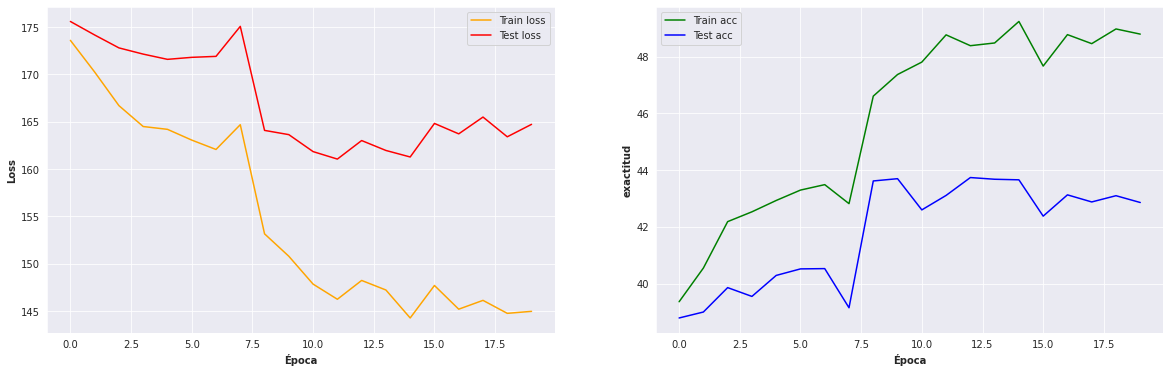

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

trn_loss, tst_loss = zip(*loss_hist)
ax0.plot(trn_loss, 'orange', label='Train loss')
ax0.plot(tst_loss, 'red', label='Test loss')
ax0.set_xlabel('Época', weight='bold')
ax0.set_ylabel('Loss', weight='bold')
ax0.legend()

trn_acc, tst_acc = zip(*acc_hist)
ax1.plot(trn_acc, 'green', label='Train acc')
ax1.plot(tst_acc, 'blue', label='Test acc')
ax1.set_xlabel('Época', weight='bold')
ax1.set_ylabel('exactitud', weight='bold')
ax1.legend()

plt.show()

In [17]:
# Evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trainloader, model)
# Evaluamos en prueba
tst_loss, tst_acc = eval_epoch(testloader, model)

print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[144.96,164.73] acc=[48.80,42.86]


### Predicciones

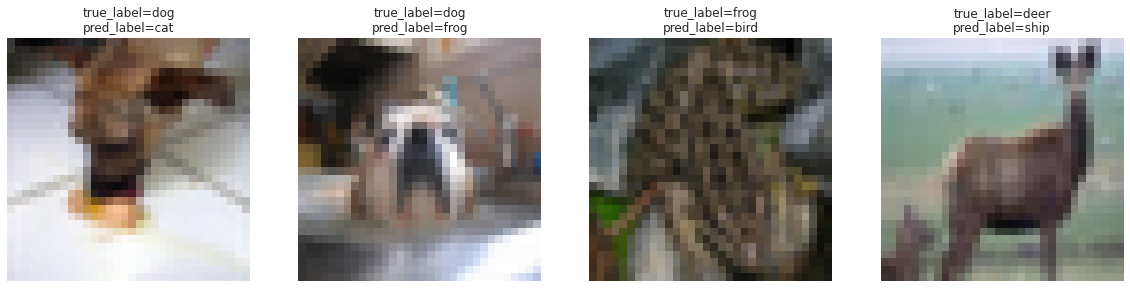

In [28]:
with torch.no_grad(): 
    images, true_labels = next(iter(testloader))
    y_lgts = model(images)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    pred_labels = list(y_pred.numpy())

    show_images(images, true_labels, pred_labels)